# Table of Contents
1. [Unsupervised Learning with Auto-Encoders](#1)
1. [Preprocessing](#2)
1. [Visualising clusters with t-SNE](#3)
1. [Train/Validate/Test split](#4)
1. [Normalising & Standardising](#5)
1. [Training the auto-encoder](#6)
1. [Reconstructions](#7)
1. [Setting a threshold for classification](#8)
1. [Latent Space ](#9)
1. [Conclusion](#10)

<a id="1"></a> <br>
# Unsupervised Learning with Auto-Encoders

If you are interested in an introduction to auto-encoders, head over to [Julien Despois' article](https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df).
If a more technical breakdown is what you are looking for, check out [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) from which the below image is sourced.
It illustrates the functioning of an auto-encoder for MNIST images, but the concept is the same.
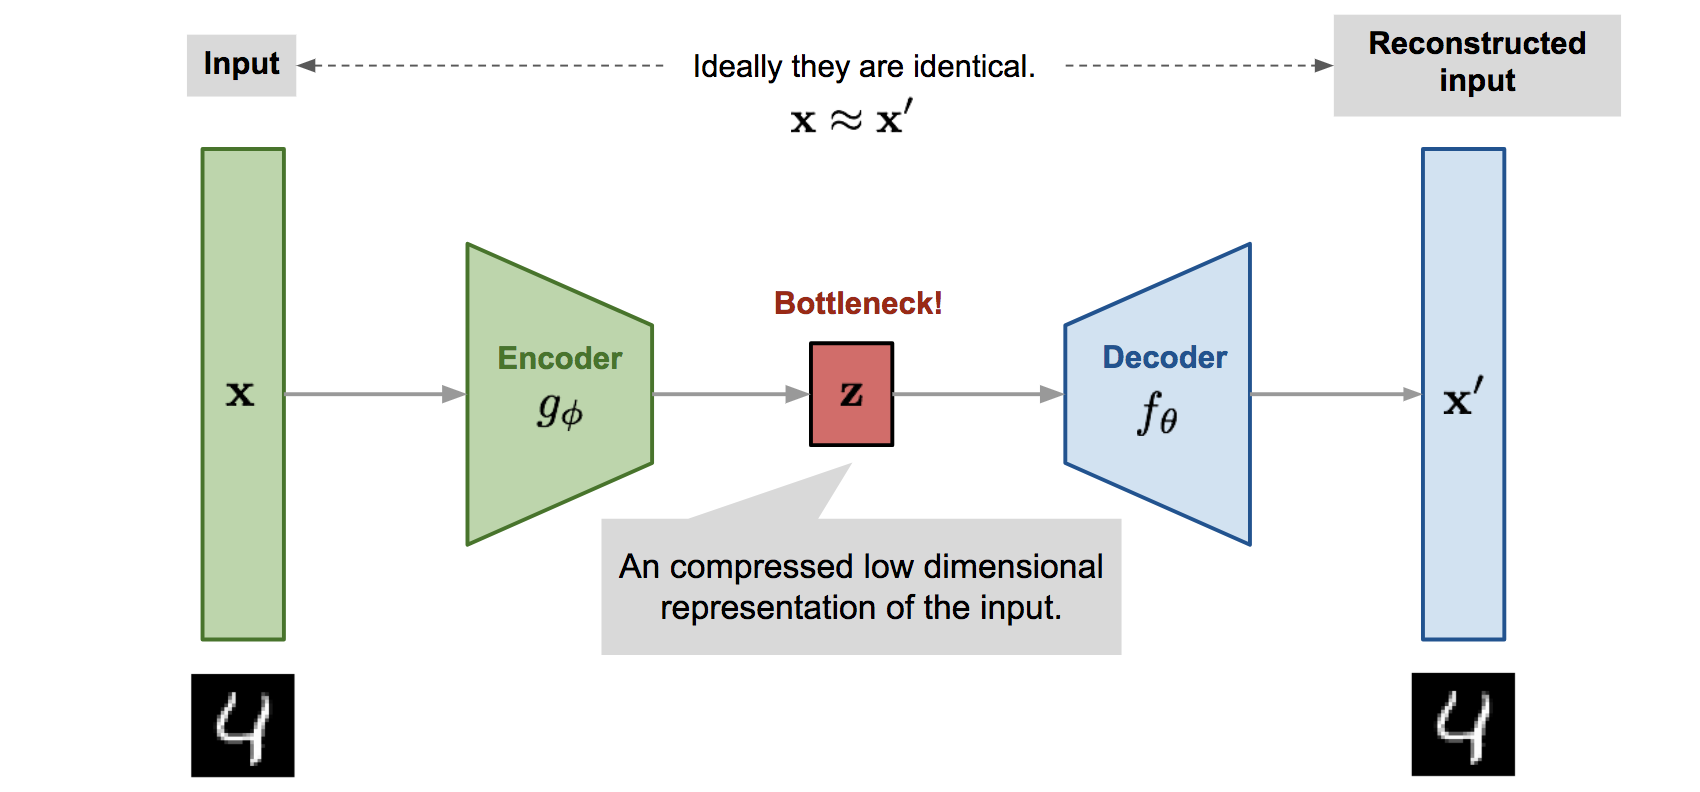

The idea is quite straightforward:
1. Due to the **bottleneck architecture** of the neural network, it is forced to learn a **condensed representation** from which to reproduce the original input.
2. We feed it **only normal transactions**, which it will learn to reproduce with high fidelity.
3. As a consequence, if a **fraud transaction is sufficiently distinct** from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent **reconstruction loss will be high**.
4. Anything above a specific loss (treshold) will be **flagged as anomalous** and thus labeled as fraud.

<a id="2"></a> <br>
# Preprocessing

## Import Libraries & set Random Seeds

In [1]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn

# load the dataset
#url='https://raw.githubusercontent.com/wujinja-cgu/Model-Selection-By-Caret-Package/main/sepsis%20data.csv'
df = pd.read_csv('sepsis data.csv')

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 555
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(42)

C:\Users\wujin\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Renaming columns

In [2]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
#df.columns = map(str.lower, df.columns)
#df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

death   pct         crp    lactate   alb  ddimer   rdw
0      0  0.37  257.000000  28.700001  3.75  2427.0  13.7
1      0  0.15  154.899994   9.000000  2.73  1915.0  13.9
2      0  0.09   75.699997  13.800000  3.06   544.0  14.1
3      0  0.54  204.100006   9.200000  3.42  2427.0  12.9
4      0  0.92   74.099998  32.700001  4.42  1956.0  12.5

## Calculated field: log10(amount)

Turn the amount feature into a normally distributed log equivalent.

In [4]:
# add a negligible amount to avoid taking the log of 0
df['log10_crp'] = np.log10(df.crp + 0.00001)

In [5]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['death', 'log10_crp']] + 
    ['log10_crp', 'death']
]

<a id="3"></a> <br>
# Visualising clusters with t-SNE
*t-Distributed Stochastic Neighbor Embedding (t-SNE)*

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): <br>
> t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: **t-SNE is a dimensionality reduction technique used for visualisations** of complex datasets.
It **maps clusters in high-dimensional data** to **a two- or three dimensional plane** so we can get an idea of how easy it will be to **discriminate between classes**.
It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

A more elaborate [introduction](https://www.datacamp.com/community/tutorials/introduction-t-sne) is available on DataCamp.

## Undersampling the non-fraud
To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).

In [6]:
# manual parameter 
RATIO_TO_FRAUD = 11.33

# dropping redundant columns
#df = df.drop(['time', 'amount'], axis=1)

# splitting by class
Death = df[df.death == 1]
Survival = df[df.death == 0]

In [7]:
len(Death)

45

In [8]:
# undersample clean transactions
Survival_undersampled = Survival.sample(
    int(len(Death) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([Death, Survival_undersampled])
column_names = list(visualisation_initial.drop('death', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('death', axis=1).values, \
                   visualisation_initial.death.values

In [9]:
print(f"""The non-death dataset has been undersampled from {len(Survival):,} to {len(Survival_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to Death.""")

The non-death dataset has been undersampled from 510 to 509.
This represents a ratio of 11.33:1 to Death.


## t-SNE output

In [10]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Death'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Survival'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

<IPython.core.display.Javascript object>


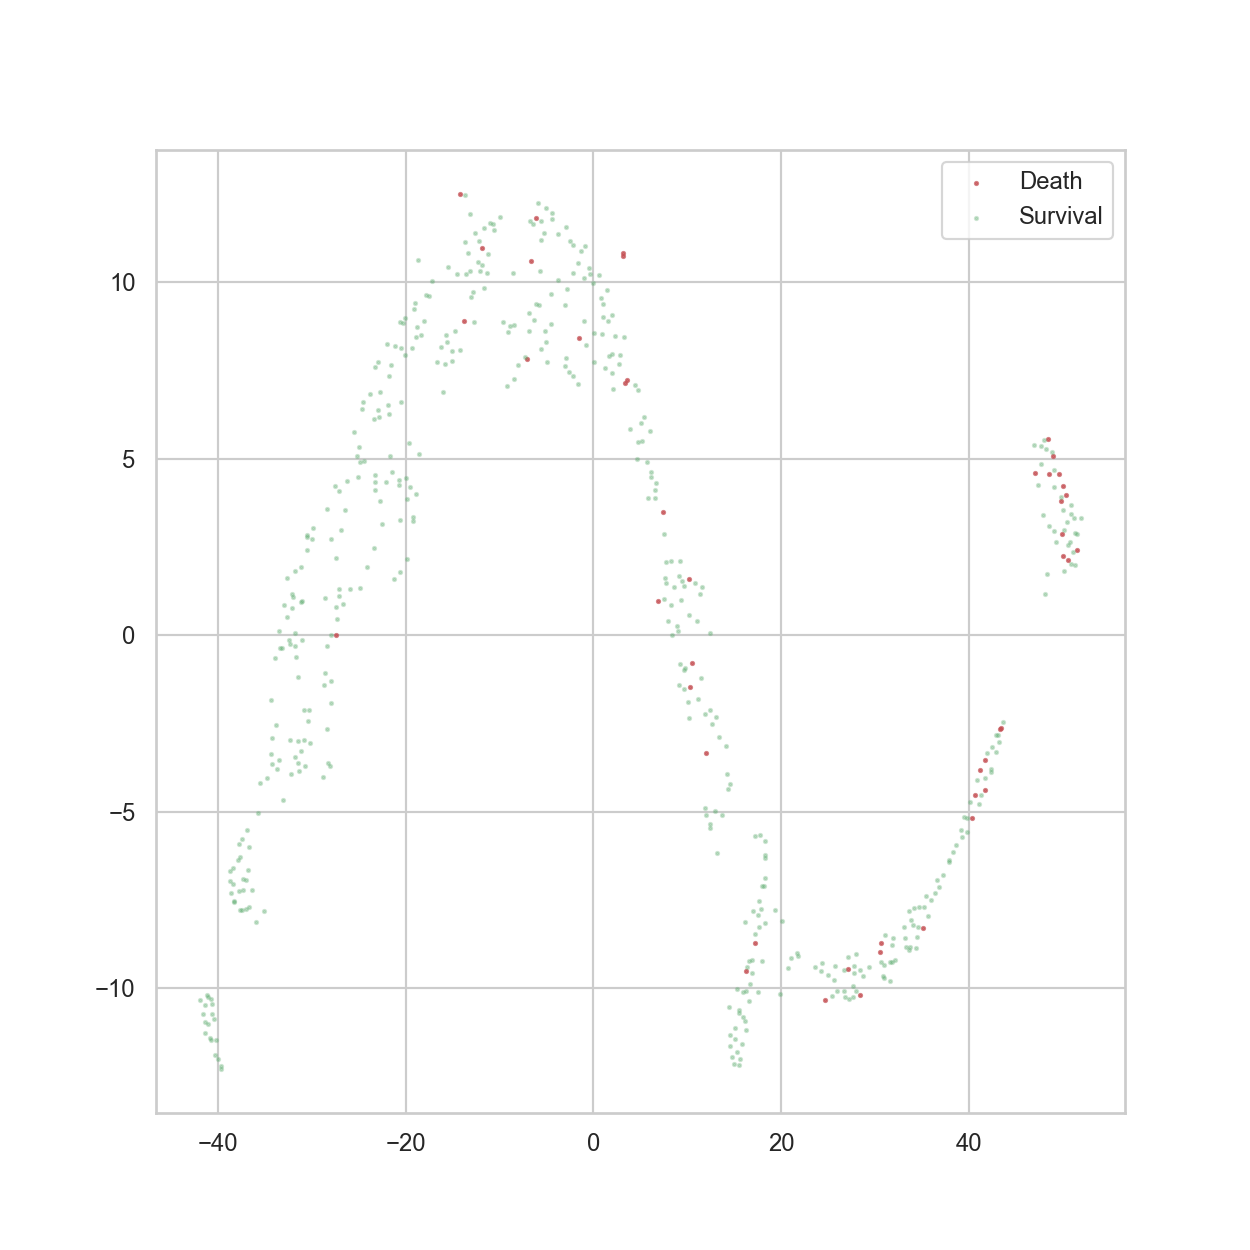

In [11]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

Some clusters are apparent, but a minority of fraud transactions remains sneaky, sneaky.

<a id="4"></a> <br>
# Train/Validate/Test split
Our auto-encoder will **only train on transactions that were normal**. 
What's left over will be combined with the fraud set to form our test sample.

We will be doing something akin to the below:
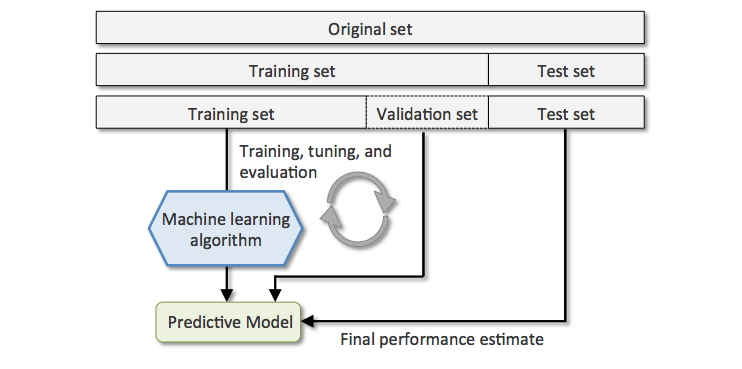
 

1. Training: only non-fraud
    * Split into:
        1. Actual training of our autoencoder
        2. Validation of the neural network's ability to generalize
2. Testing : mix of fraud and non-fraud
    * Treated like new data
    * Attempt to locate outliers
        1. Compute reconstruction loss
        2. Apply threshold

In [12]:
print(f"""Shape of the datasets:
    Survival (rows, cols) = {Survival.shape}
    Death (rows, cols) = {Death.shape}""")

Shape of the datasets:
    Survival (rows, cols) = (510, 8)
    Death (rows, cols) = (45, 8)


In [13]:
# shuffle our training set
Survival = Survival.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = Survival.iloc[:TRAINING_SAMPLE].drop('death', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = Survival.iloc[TRAINING_SAMPLE:].append(Death).sample(frac=1)

C:\Users\wujin\AppData\Local\Temp\ipykernel_11464\2601423892.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = Survival.iloc[TRAINING_SAMPLE:].append(Death).sample(frac=1)


In [14]:
print(f"""Our testing set is composed as follows:

{X_test.death.value_counts()}""")

Our testing set is composed as follows:

1    45
Name: death, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('death', axis=1).values, X_test.death.values

## Summary

In [16]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (408, 7)
    validate (rows, cols) = (102, 7)
    holdout  (rows, cols) = (45, 7)


<a id="5"></a> <br>
# Normalising & Standardising 

## Why
In an [excellent article by Jeremy Jordan](https://www.jeremyjordan.me/batch-normalization/), it is explained why making sure your data is normally distributed can **help stochastic gradient descent converge** more effectively.
In a nutshell:
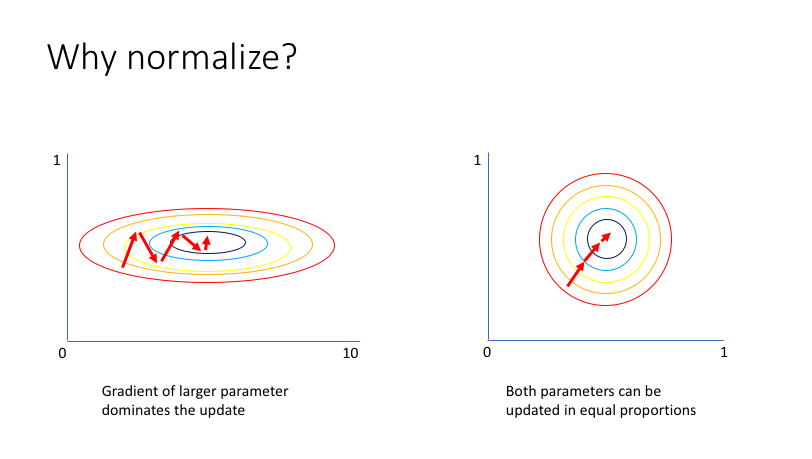


## When
At what point in the data processing do we apply standardisation/normalisation? <br>
An [excellent answer was provided on StackOverflow](https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data).

> Don't forget that **testing data points represent real-world data**. Feature normalization (or data standardization) of the explanatory (or predictor) variables is a technique used to center and normalise the data by subtracting the mean and dividing by the variance. **If you take the mean and variance of the whole dataset you'll be introducing future information into the training explanatory variables** (i.e. the mean and variance).
> 
> Therefore, you should **perform feature normalisation over the training data**. Then **perform normalisation on testing **instances as well, but this time **using the mean and variance of training** explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.
>
> <span style="font-size:10px">[Answer by [Giorgos Myrianthous](https://stackoverflow.com/users/7131757/giorgos-myrianthous)]</span>

## Building our pipeline

In [17]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

## Fitting the pipeline

In [18]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

## Applying transformations with acquired parameters

In [19]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

## Before & After

<IPython.core.display.Javascript object>


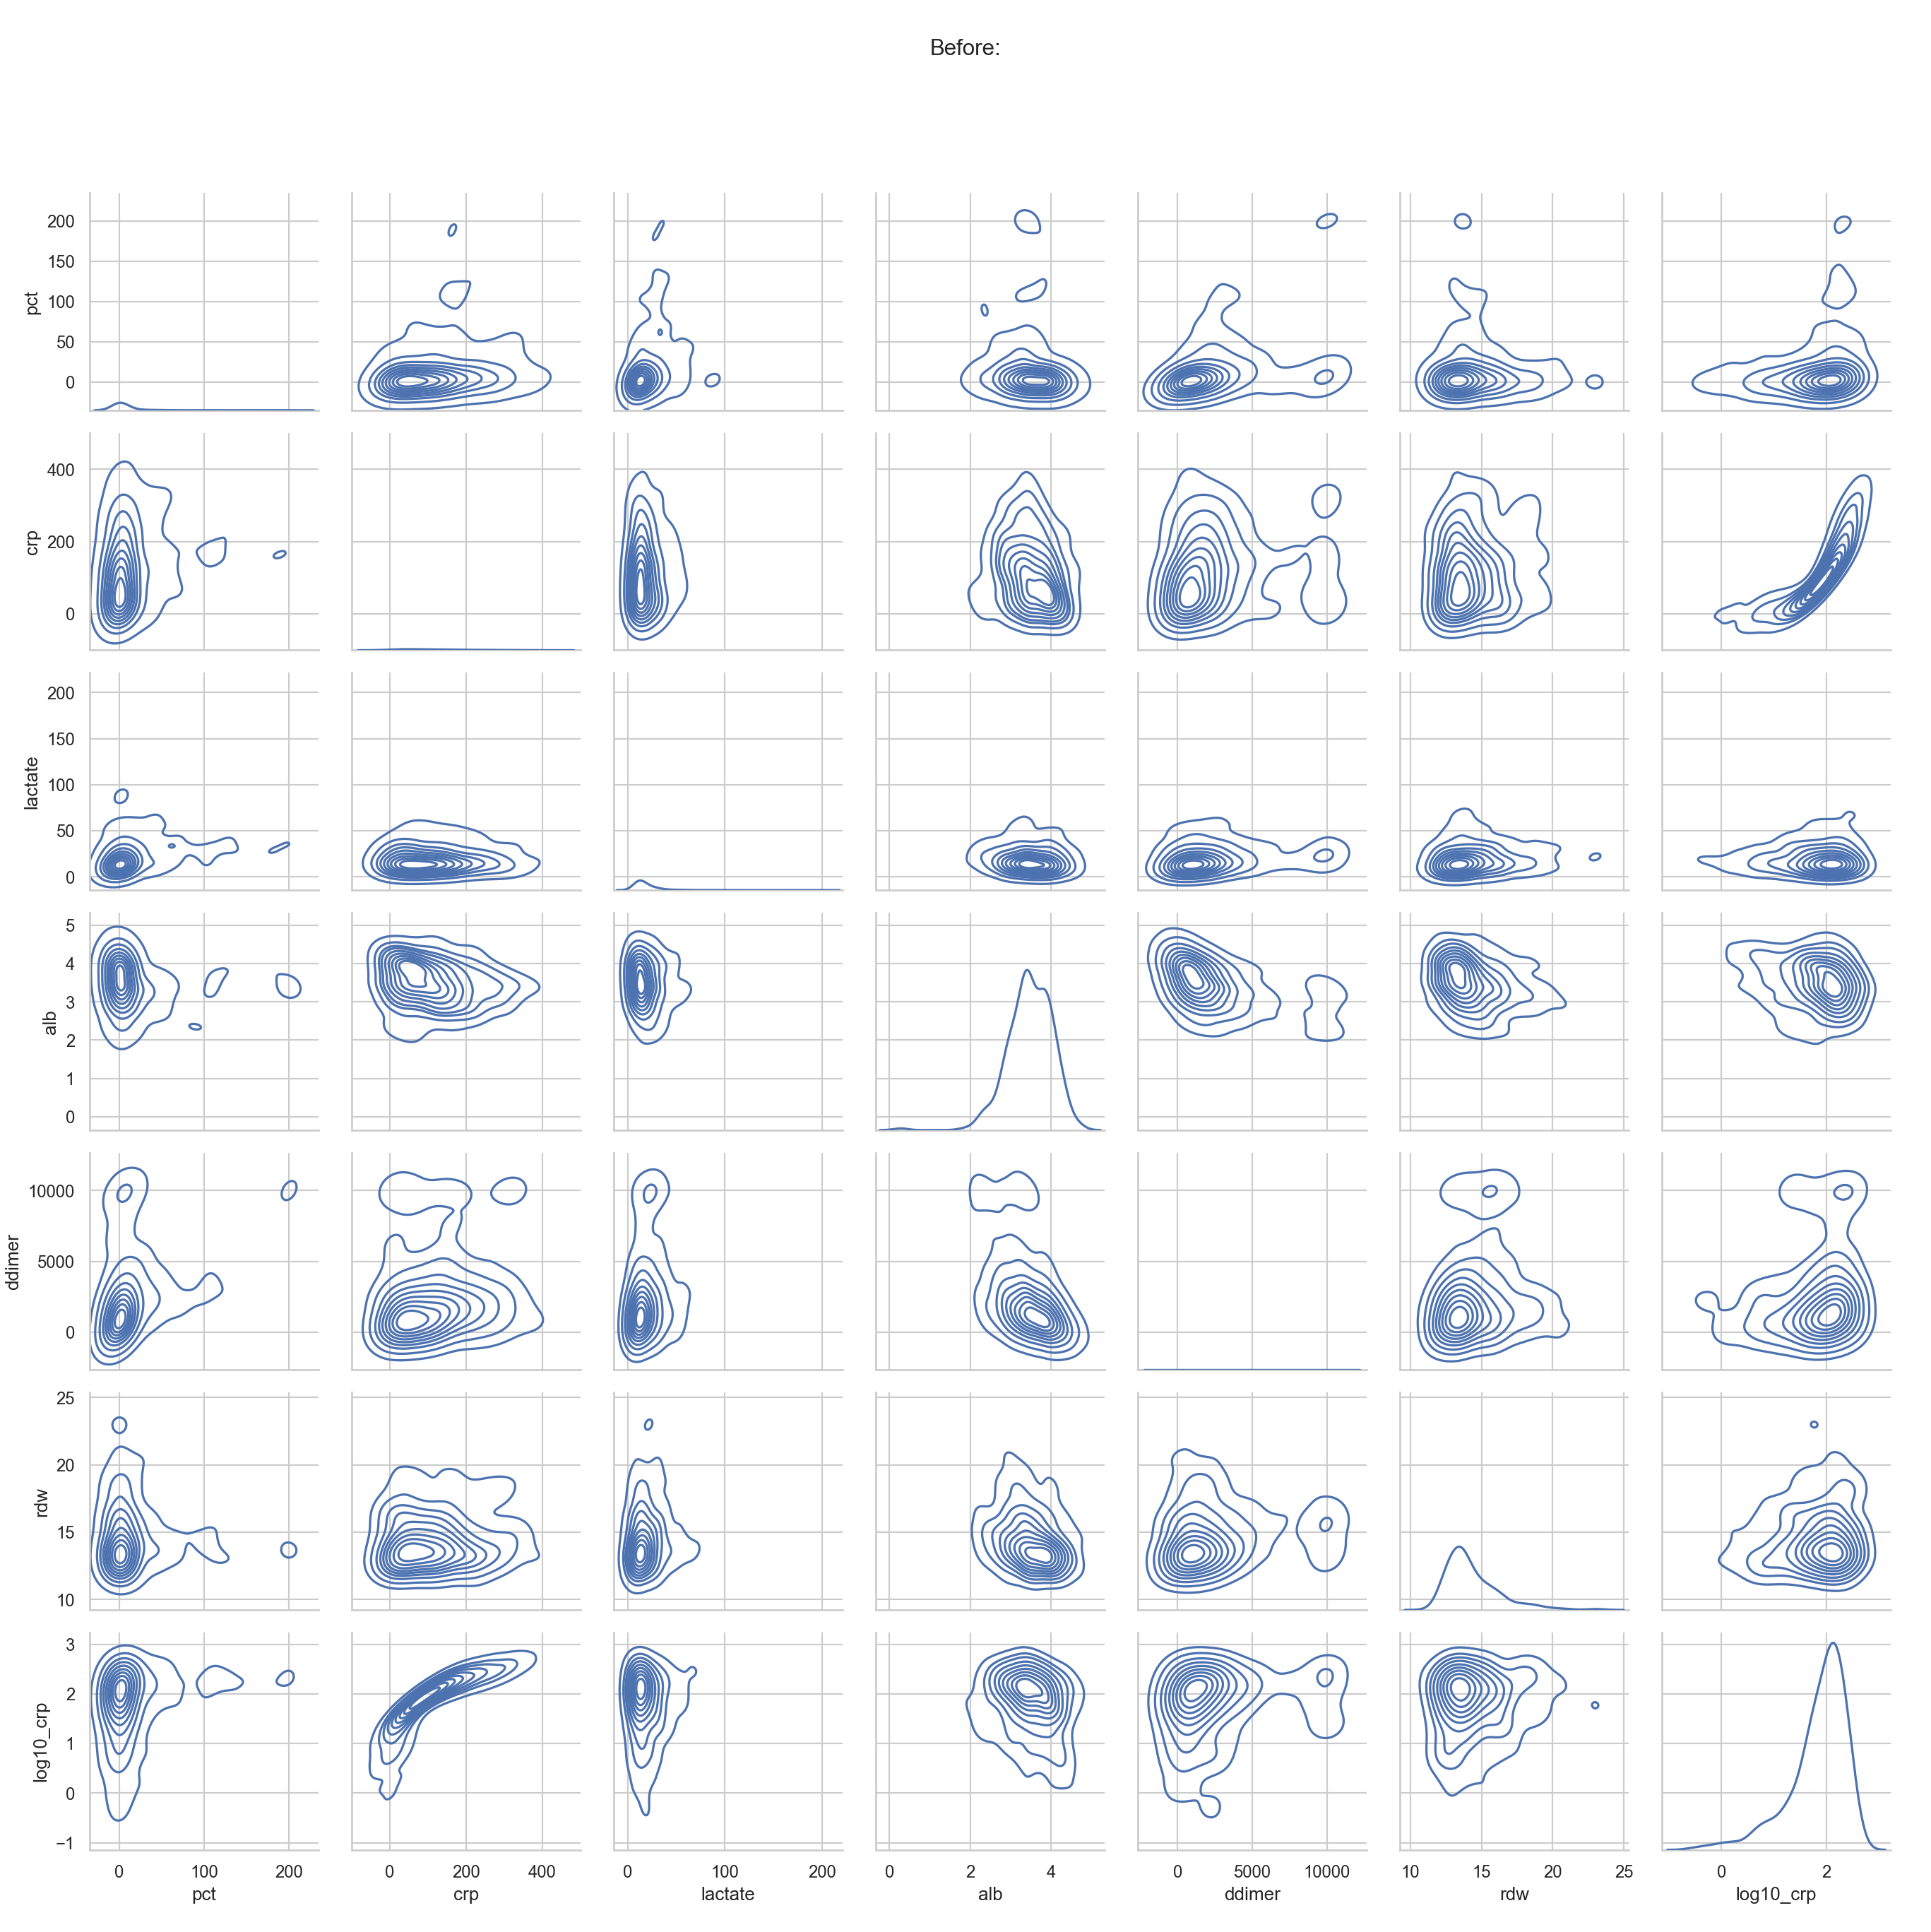

In [22]:
g = sns.PairGrid(X_train.iloc[:,:8].sample(300, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

<IPython.core.display.Javascript object>


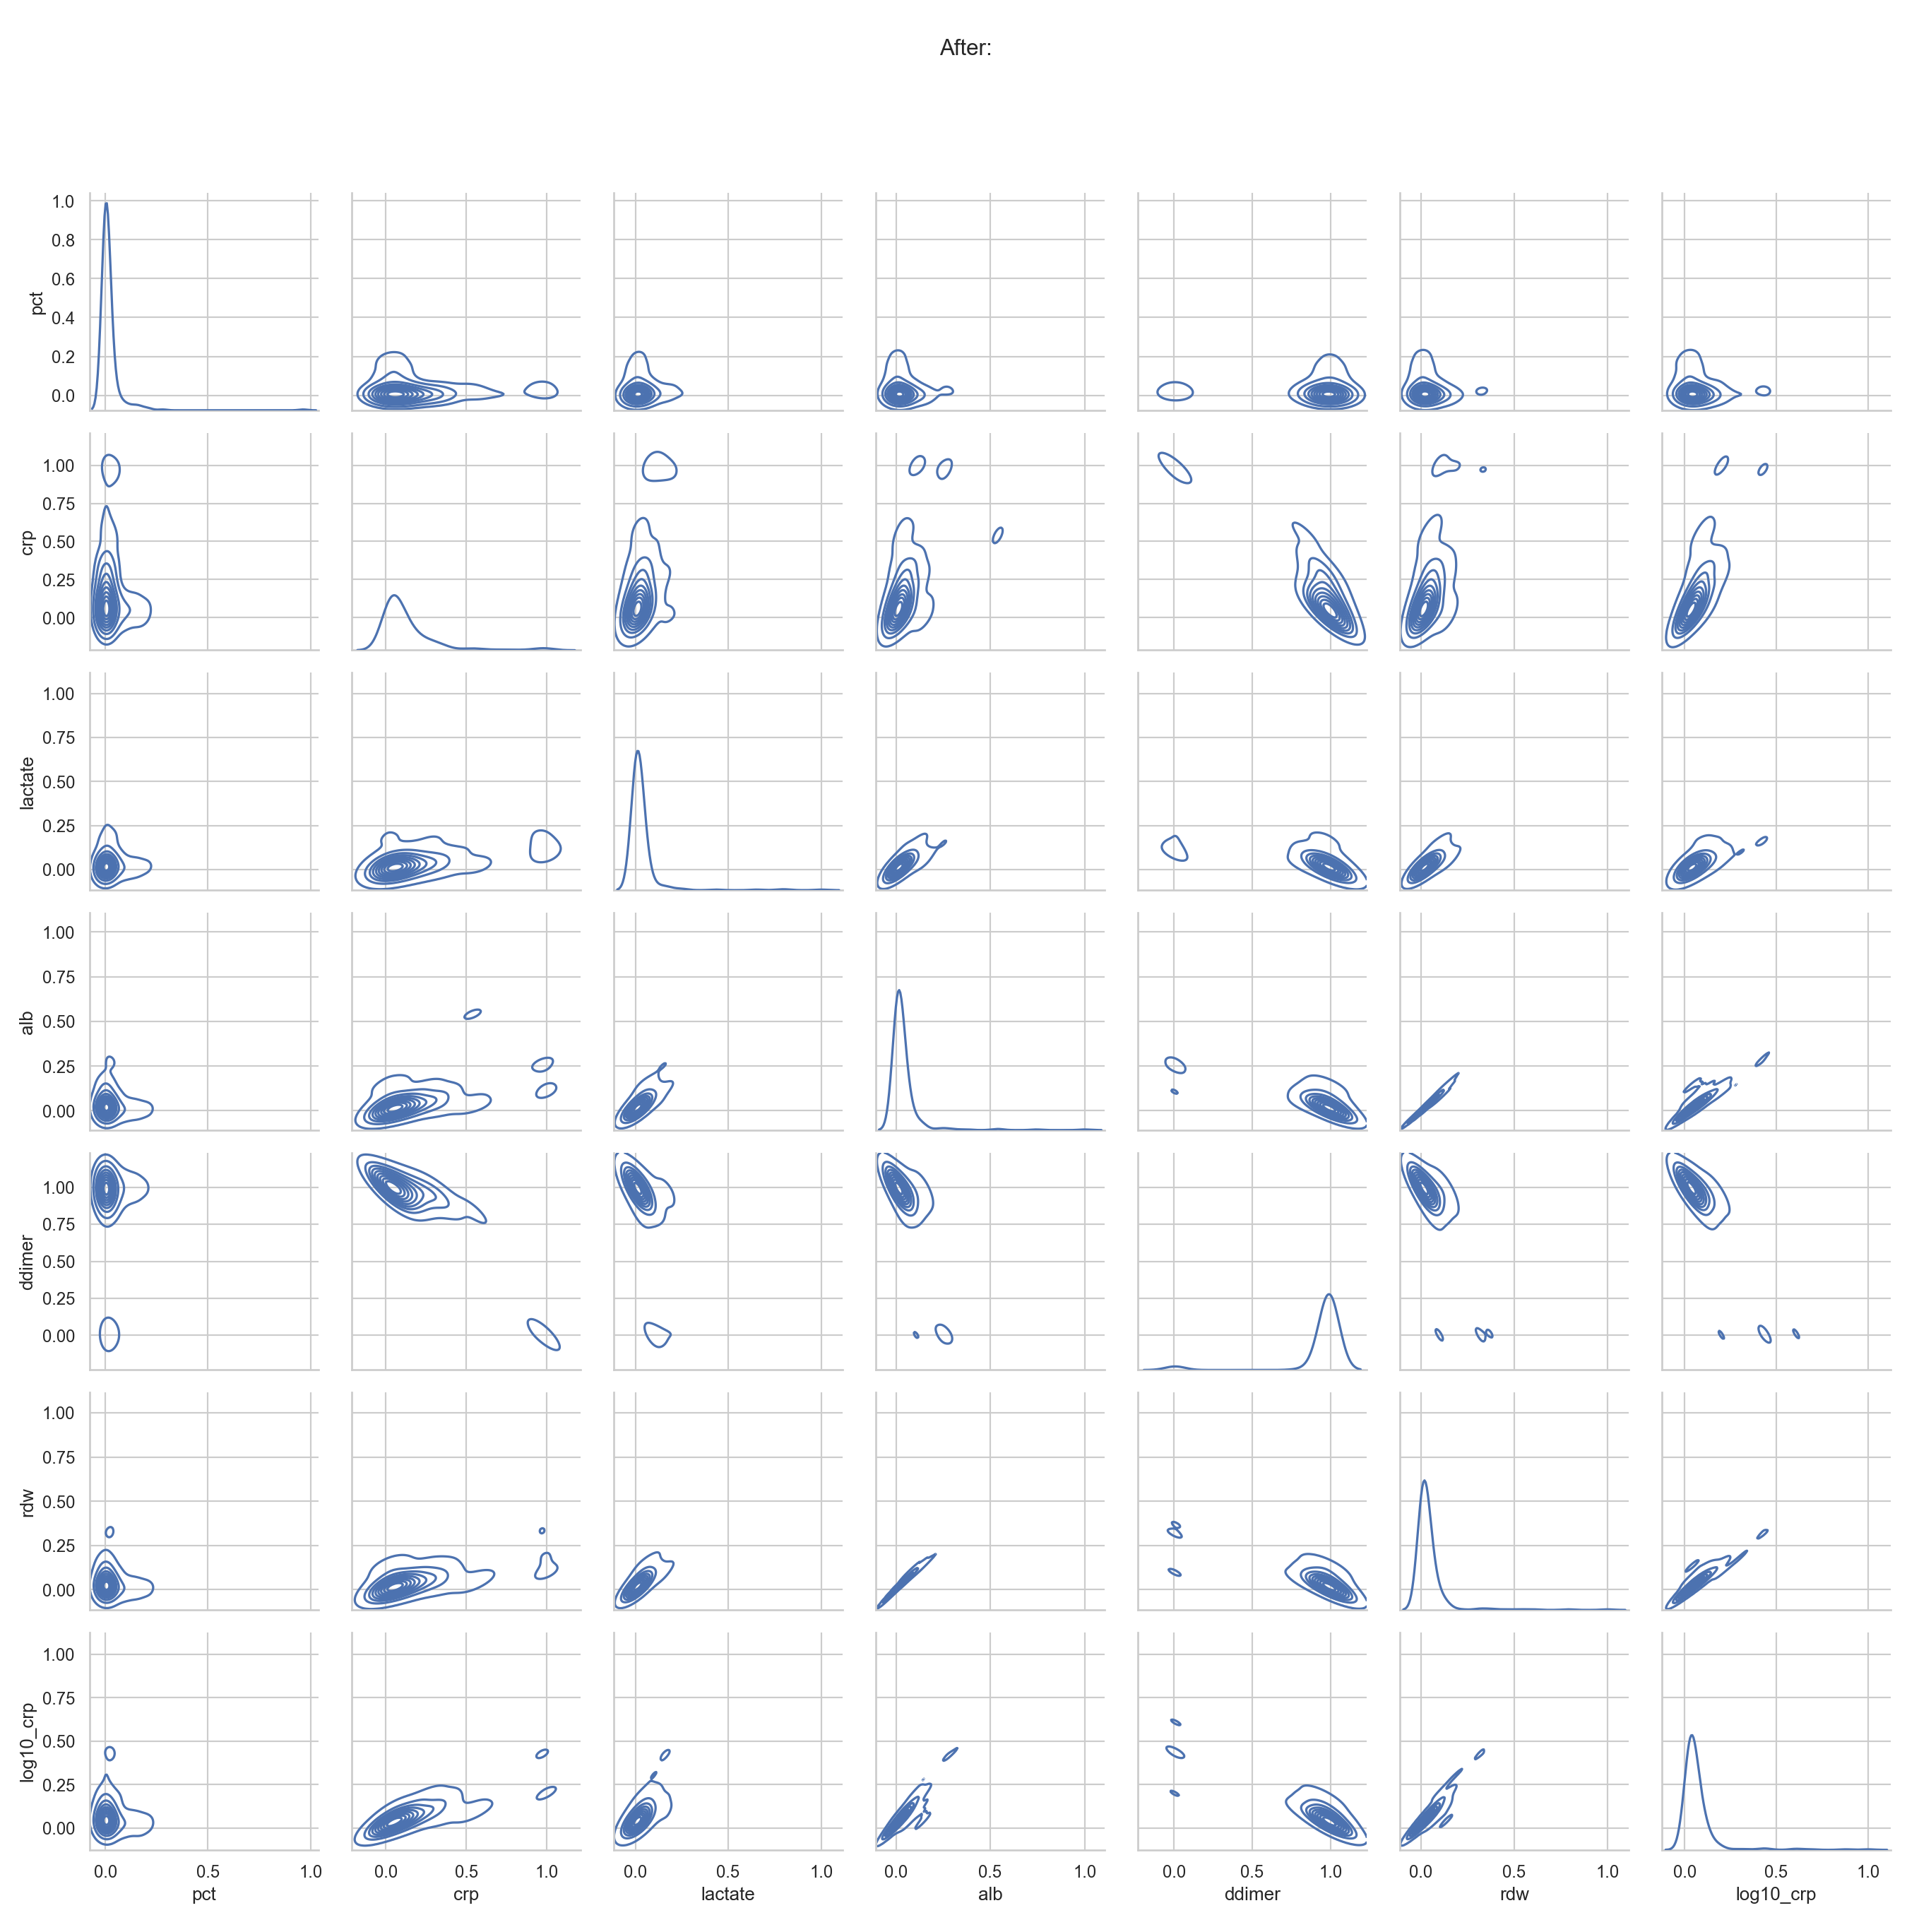

In [23]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:8].sample(300, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

We can tell the data is slightly more **uniform and proportionally distributed**. <br>
The ranges were also shrunk to fit **between 0 and 1**.

<a id="6"></a> <br>
# Training the auto-encoder


## TensorBoard
As documented in [this kernel by Aurelio Agundez](https://www.kaggle.com/aagundez/using-tensorboard-in-kaggle-kernels), TensorBoard requires a running kernel, so its output will only be available in an editor session.
Fork this notebook if you wish to interact with it.

#!pip install --upgrade tensorboard
#!pip install --upgrade markdown

In [24]:
# Load the extension and start TensorBoard
#%load_ext tensorboard.notebook
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23440), started 0:29:44 ago. (Use '!kill 23440' to kill it.)

## Architecture of our model
Keras has become the standard high-level API within Tensorflow. No surprise, it's awesome.
Check out their [blog post on the topic of autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

In [25]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 16)                128       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 8)                 4

## Callbacks

* Continue as long as the model is reducing the training loss.
* Save only the weights for the model with the lowest validation loss, though.
* Get graphical insights with Tensorboard.

In [26]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

## Training

In [27]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
2/2 [==============================] - 3s 438ms/step - loss: 0.4450 - acc: 0.0049 - val_loss: 0.4023 - val_acc: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 104ms/step - loss: 0.3980 - acc: 0.0049 - val_loss: 0.3572 - val_acc: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 100ms/step - loss: 0.3545 - acc: 0.0049 - val_loss: 0.3154 - val_acc: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 99ms/step - loss: 0.3140 - acc: 0.0049 - val_loss: 0.2763 - val_acc: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 95ms/step - loss: 0.2758 - acc: 0.0049 - val_loss: 0.2400 - val_acc: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 102ms/step - loss: 0.2404 - acc: 0.0049 - val_loss: 0.2069 - val_acc: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 106ms/step - loss: 0.2081 - acc: 0.0049 - val_loss: 0.1780 - val_acc: 0.0000e+00
Epoch 8/100
2/2 [==============================] - 0s 102

Epoch 63/100
2/2 [==============================] - 0s 98ms/step - loss: 0.0144 - acc: 0.9583 - val_loss: 0.0089 - val_acc: 0.9804
Epoch 64/100
2/2 [==============================] - 0s 94ms/step - loss: 0.0143 - acc: 0.9583 - val_loss: 0.0088 - val_acc: 0.9804
Epoch 65/100
2/2 [==============================] - 0s 93ms/step - loss: 0.0142 - acc: 0.9583 - val_loss: 0.0088 - val_acc: 0.9804
Epoch 66/100
2/2 [==============================] - 0s 95ms/step - loss: 0.0142 - acc: 0.9583 - val_loss: 0.0088 - val_acc: 0.9804
Epoch 67/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0141 - acc: 0.9583 - val_loss: 0.0088 - val_acc: 0.9804
Epoch 68/100
2/2 [==============================] - 0s 93ms/step - loss: 0.0140 - acc: 0.9583 - val_loss: 0.0087 - val_acc: 0.9804
Epoch 69/100
2/2 [==============================] - 0s 96ms/step - loss: 0.0140 - acc: 0.9583 - val_loss: 0.0087 - val_acc: 0.9804
Epoch 70/100
2/2 [==============================] - 0s 99ms/step - loss: 0.0139 - 

<a id="7"></a> <br>
# Reconstructions

We **apply the transformation pipeline to our test set**. <br>
Then, we **pass the data through the trained autoencoder**.

In [28]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

C:\Users\wujin\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2/2 [==============================] - 0s 4ms/step


**Calculate the reconstruction loss** for every transaction and draw a sample.

In [29]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

<IPython.core.display.Javascript object>


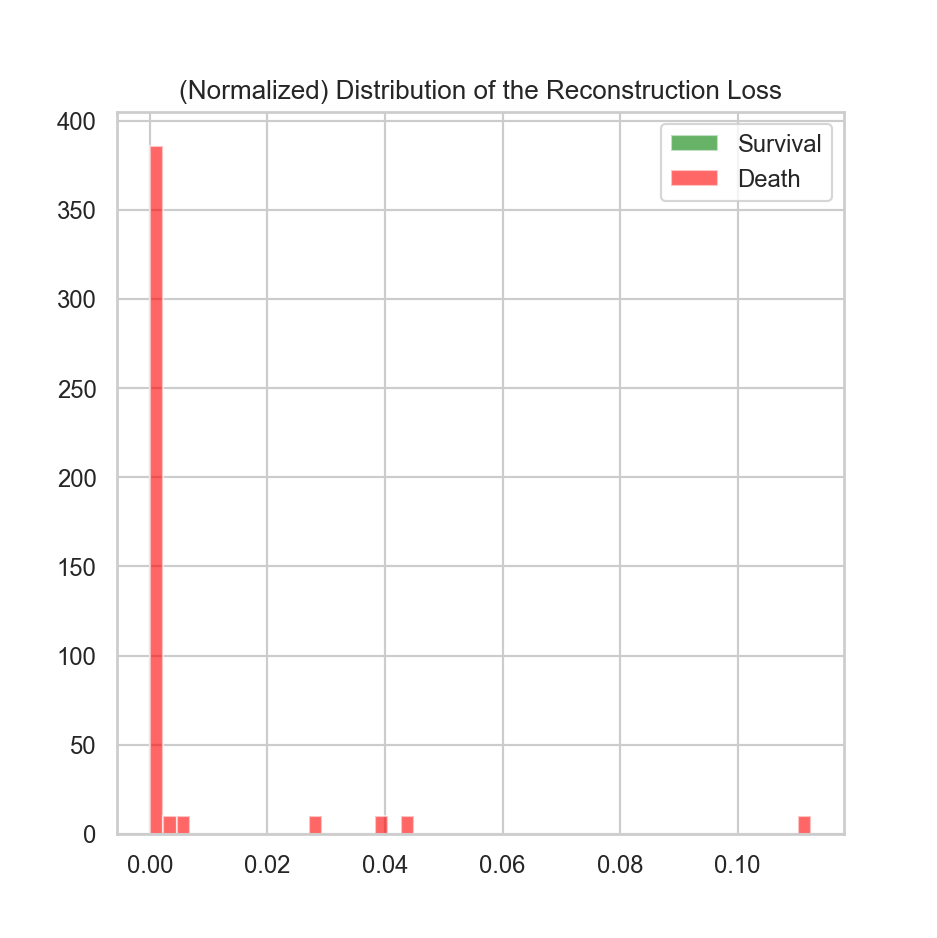

C:\Users\wujin\anaconda3\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [30]:
Survival = mse[y_test==0]
Death = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(Survival, bins=50, density=True, label="Survival", alpha=.6, color="green")
ax.hist(Death, bins=50, density=True, label="Death", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

<a id="8"></a> <br>
# Setting a threshold for classification

## Unsupervised
Normally, in an unsupervised solution, this is where the story would end. We would **set a threshold that limits the amount of false positives** to a manageable degree, **and captures the most anomalous data points**.

### Percentiles 
We could set this threshold by taking the top x% of the dataset and considering it anomalous.

### MAD
We could also use a **modified Z-score using the Median Absolute Deviation to define outliers** on our reconstruction data. Here is a [good blog post on the topic](https://medium.com/james-blogs/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7) by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [31]:
THRESHOLD = 3

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [32]:
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 5 outliers in a total of 45 transactions [11.11%].


## Supervised
We know the labels, so we can verify our results.

### Classification Matrix on MAD outliers
A closer look:

In [33]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

In [34]:
print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
{cm}

% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
% of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")

The classifications using the MAD method with threshold=3 are as follows:
[[ 0  0]
 [40  5]]

% of transactions labeled as fraud that were correct (precision): 5/(0+5) = 100.00%
% of fraudulent transactions were caught succesfully (recall):    5/(40+5) = 11.11%


### Asymmetric error cost
In the real world, we can expect **different costs associated with reporting a false positive versus reporting a false negative**. Missing a fraud case is likely to be much more costly than wrongly flagging a transaction as one. In [another kernel](https://www.kaggle.com/robinteuwens/fraud-detection-as-a-cost-optimization-problem/comments), I discuss an approach to determining these costs for this dataset in depth. 

### Recall & Precision
Generally speaking, you will have to prioritise what you find more important. This dilemma is commonly called the **"recall vs precision" trade-off**.
If you want to increase recall, **adjust the MAD's Z-Score threshold** downwards, if you want recover precision, increase it.

<IPython.core.display.Javascript object>


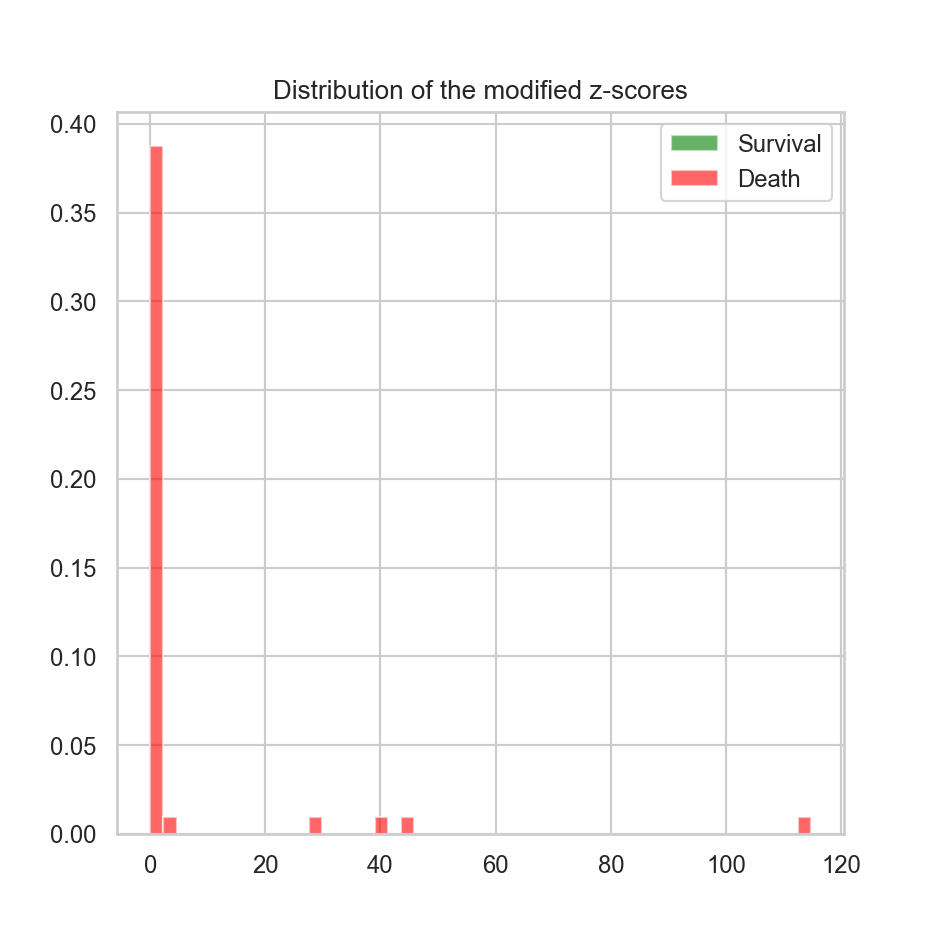

C:\Users\wujin\anaconda3\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [35]:
Survival = z_scores[y_test==0]
Death = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(Survival, bins=50, density=True, label="Survival", alpha=.6, color="green")
ax.hist(Death, bins=50, density=True, label="Death", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

<a id="9"></a> <br>
# Latent Space 
It is always interesting to look at the **compressed representation** our neural network devised.

## Encoder
Let's build the encoder that gets us to the bottleneck. We take the layers from our autoencoder.

In [36]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 16)                128       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


## Undersampling
Consistent with the previous t-sne visualisation, let's undersample the Survival transactions.

In [37]:
# taking all the Death, undersampling Survival
Death = X_test_transformed[y_test==1]
Survival = X_test_transformed[y_test==0][:len(Death) * 11, ]

# combining arrays & building labels
features = np.append(Death, Survival, axis=0)
labels = np.append(np.ones(len(Death)),
                   np.zeros(len(Survival)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Survival transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(Death):,}.')
print('Shape of latent representation:', latent_representation.shape)

2/2 [==============================] - 0s 3ms/step
Survival transactions downsampled from 0 to 45.
Shape of latent representation: (45, 2)


## Visualising the Latent Space

<IPython.core.display.Javascript object>


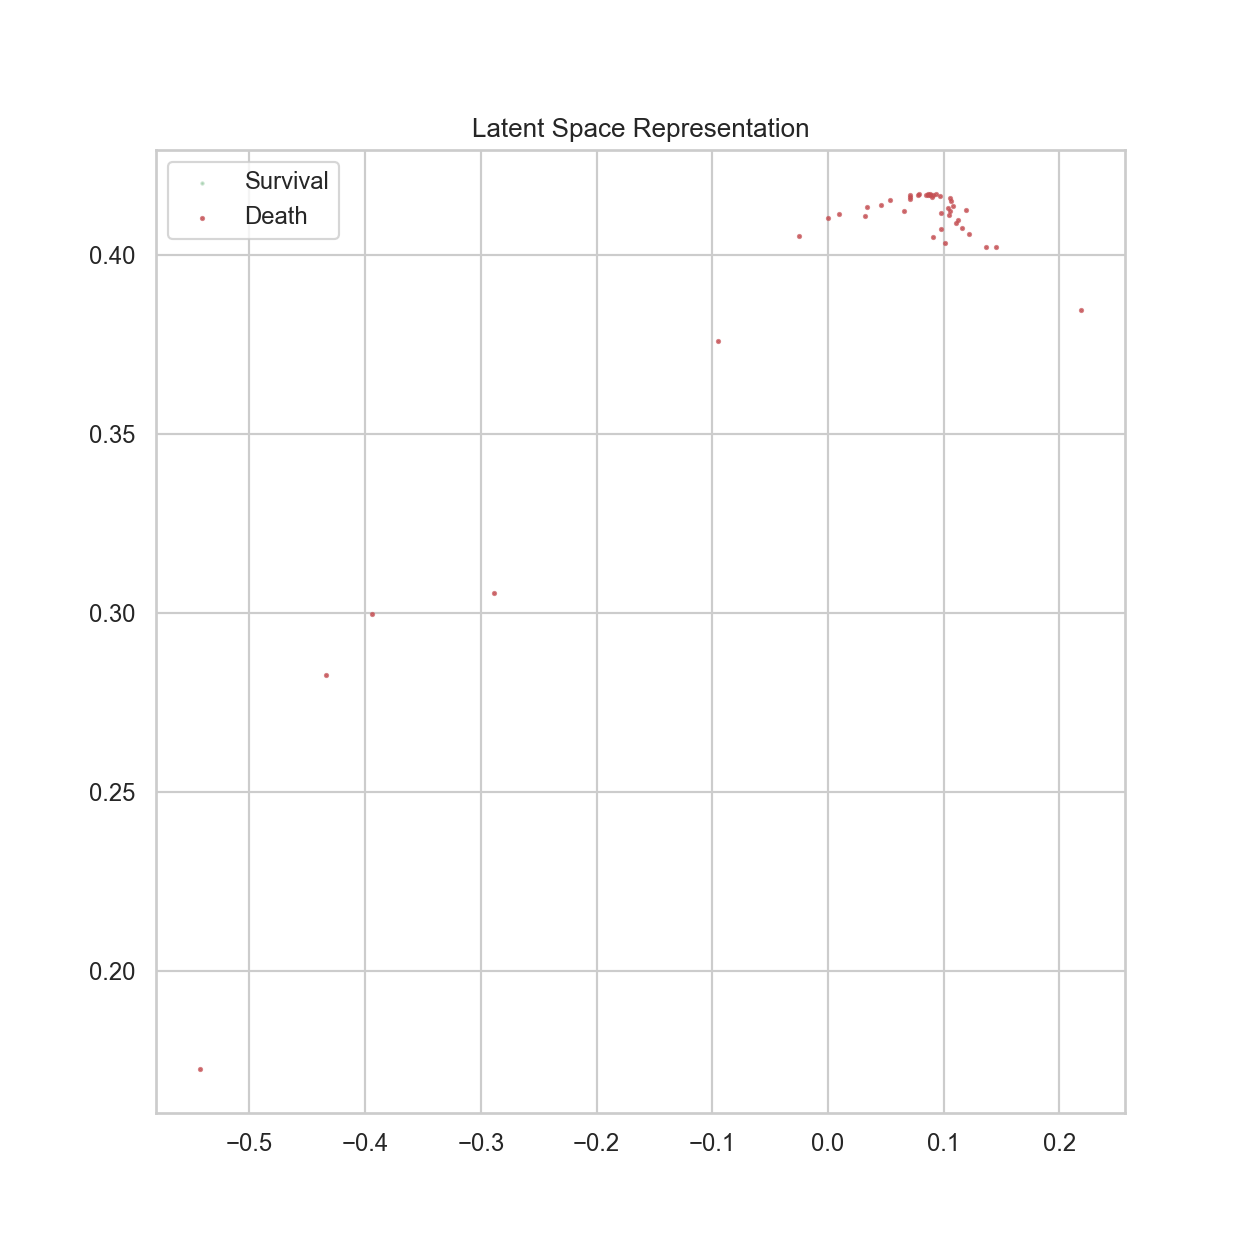

In [38]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Survival')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Death')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()